# Guided Backpropagation

In [17]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Function

from torchvision import models

import matplotlib.pyplot as plt

In [18]:
def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

In [19]:
def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

In [20]:
image_path = "../picture/dog_1.jpg"

In [21]:
class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


In [22]:
class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
            
        #
        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply
                
        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)
        
        
    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())
            
        print(f'Target Index : {index}')
        
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
            
        #VGG
        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output


In [23]:
#model = models.resnet50(pretrained=True)
model = models.vgg11(pretrained=True)

use_cuda = True

target_index = None

img = cv2.imread(image_path, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to C:\Users\ail11208/.cache\torch\checkpoints\vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [00:45<00:00, 11.6MB/s] 


In [24]:
gb_model = GuidedBackpropReLUModel(model=model, use_cuda=use_cuda)
print(model._modules.items())
gb = gb_model(input, index=target_index)
gb = gb.transpose((1, 2, 0))

#cam_mask = cv2.merge([mask, mask, mask])
#cam_gb = deprocess_image(cam_mask*gb)
gb = deprocess_image(gb)

odict_items([('features', Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): <built-in method apply of FunctionMeta object at 0x000002CD4CCCE2B8>
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): <built-in method apply of FunctionMeta object at 0x000002CD4CCCE2B8>
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): <built-in method apply of FunctionMeta object at 0x000002CD4CCCE2B8>
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): <built-in method apply of FunctionMeta object at 0x000002CD4CCCE2B8>
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): <built-in method apply of Funct

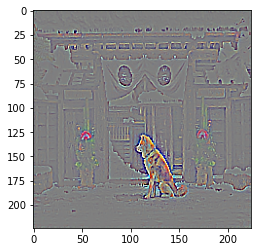

In [25]:
plt.imshow(gb)